# 📐 Notebook 05 — Pipeline & Architecture Visualization

Visualize the full ML pipeline (data flow, preprocessing, feature engineering,
modeling, and deployment). Generate clear pipeline diagrams and exportable
architecture visuals for documentation and stakeholder review.

This notebook includes: pipeline graphing (sklearn), component diagrams,
and instructions to export visuals for the docs site.

In [1]:
# === CELL 1: Setup ===
import sys
import json
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 150

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete")

✅ Setup complete


In [3]:
# === CELL 2: Visualize sklearn Pipeline Structure ===
from sklearn.utils import estimator_html_repr
from src.features.build_features import build_full_pipeline
from xgboost import XGBClassifier

pipeline = build_full_pipeline(XGBClassifier(n_estimators=100, random_state=42))

# Save HTML representation
html_repr = estimator_html_repr(pipeline)
html_path = FIGURES_DIR / "pipeline_structure.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(f"""
    <html><head><title>Pipeline Structure</title>
    <style>body {{ font-family: Arial; padding: 20px; }}</style>
    </head><body>
    <h1>Bank Marketing ML Pipeline</h1>
    {html_repr}
    </body></html>
    """)
print(f"✅ Pipeline HTML saved to {html_path}")

# Text representation
print("\nPipeline Steps:")
for i, (name, step) in enumerate(pipeline.steps):
    print(f"  Step {i+1}: {name} → {type(step).__name__}")
    if hasattr(step, "transformers"):
        for t_name, t_step, t_cols in step.transformers:
            print(f"    ├── {t_name}: {type(t_step).__name__ if not isinstance(t_step, str) else t_step}")
            if isinstance(t_cols, list):
                print(f"    │   Columns: {t_cols}")


✅ Pipeline HTML saved to c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\reports\figures\pipeline_structure.html

Pipeline Steps:
  Step 1: pdays_transform → PdaysTransformer
  Step 2: preprocessor → ColumnTransformer
    ├── num: Pipeline
    │   Columns: ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'was_previously_contacted', 'pdays_log']
    ├── ord: Pipeline
    │   Columns: ['education']
    ├── nom: Pipeline
    │   Columns: ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
  Step 3: classifier → XGBClassifier


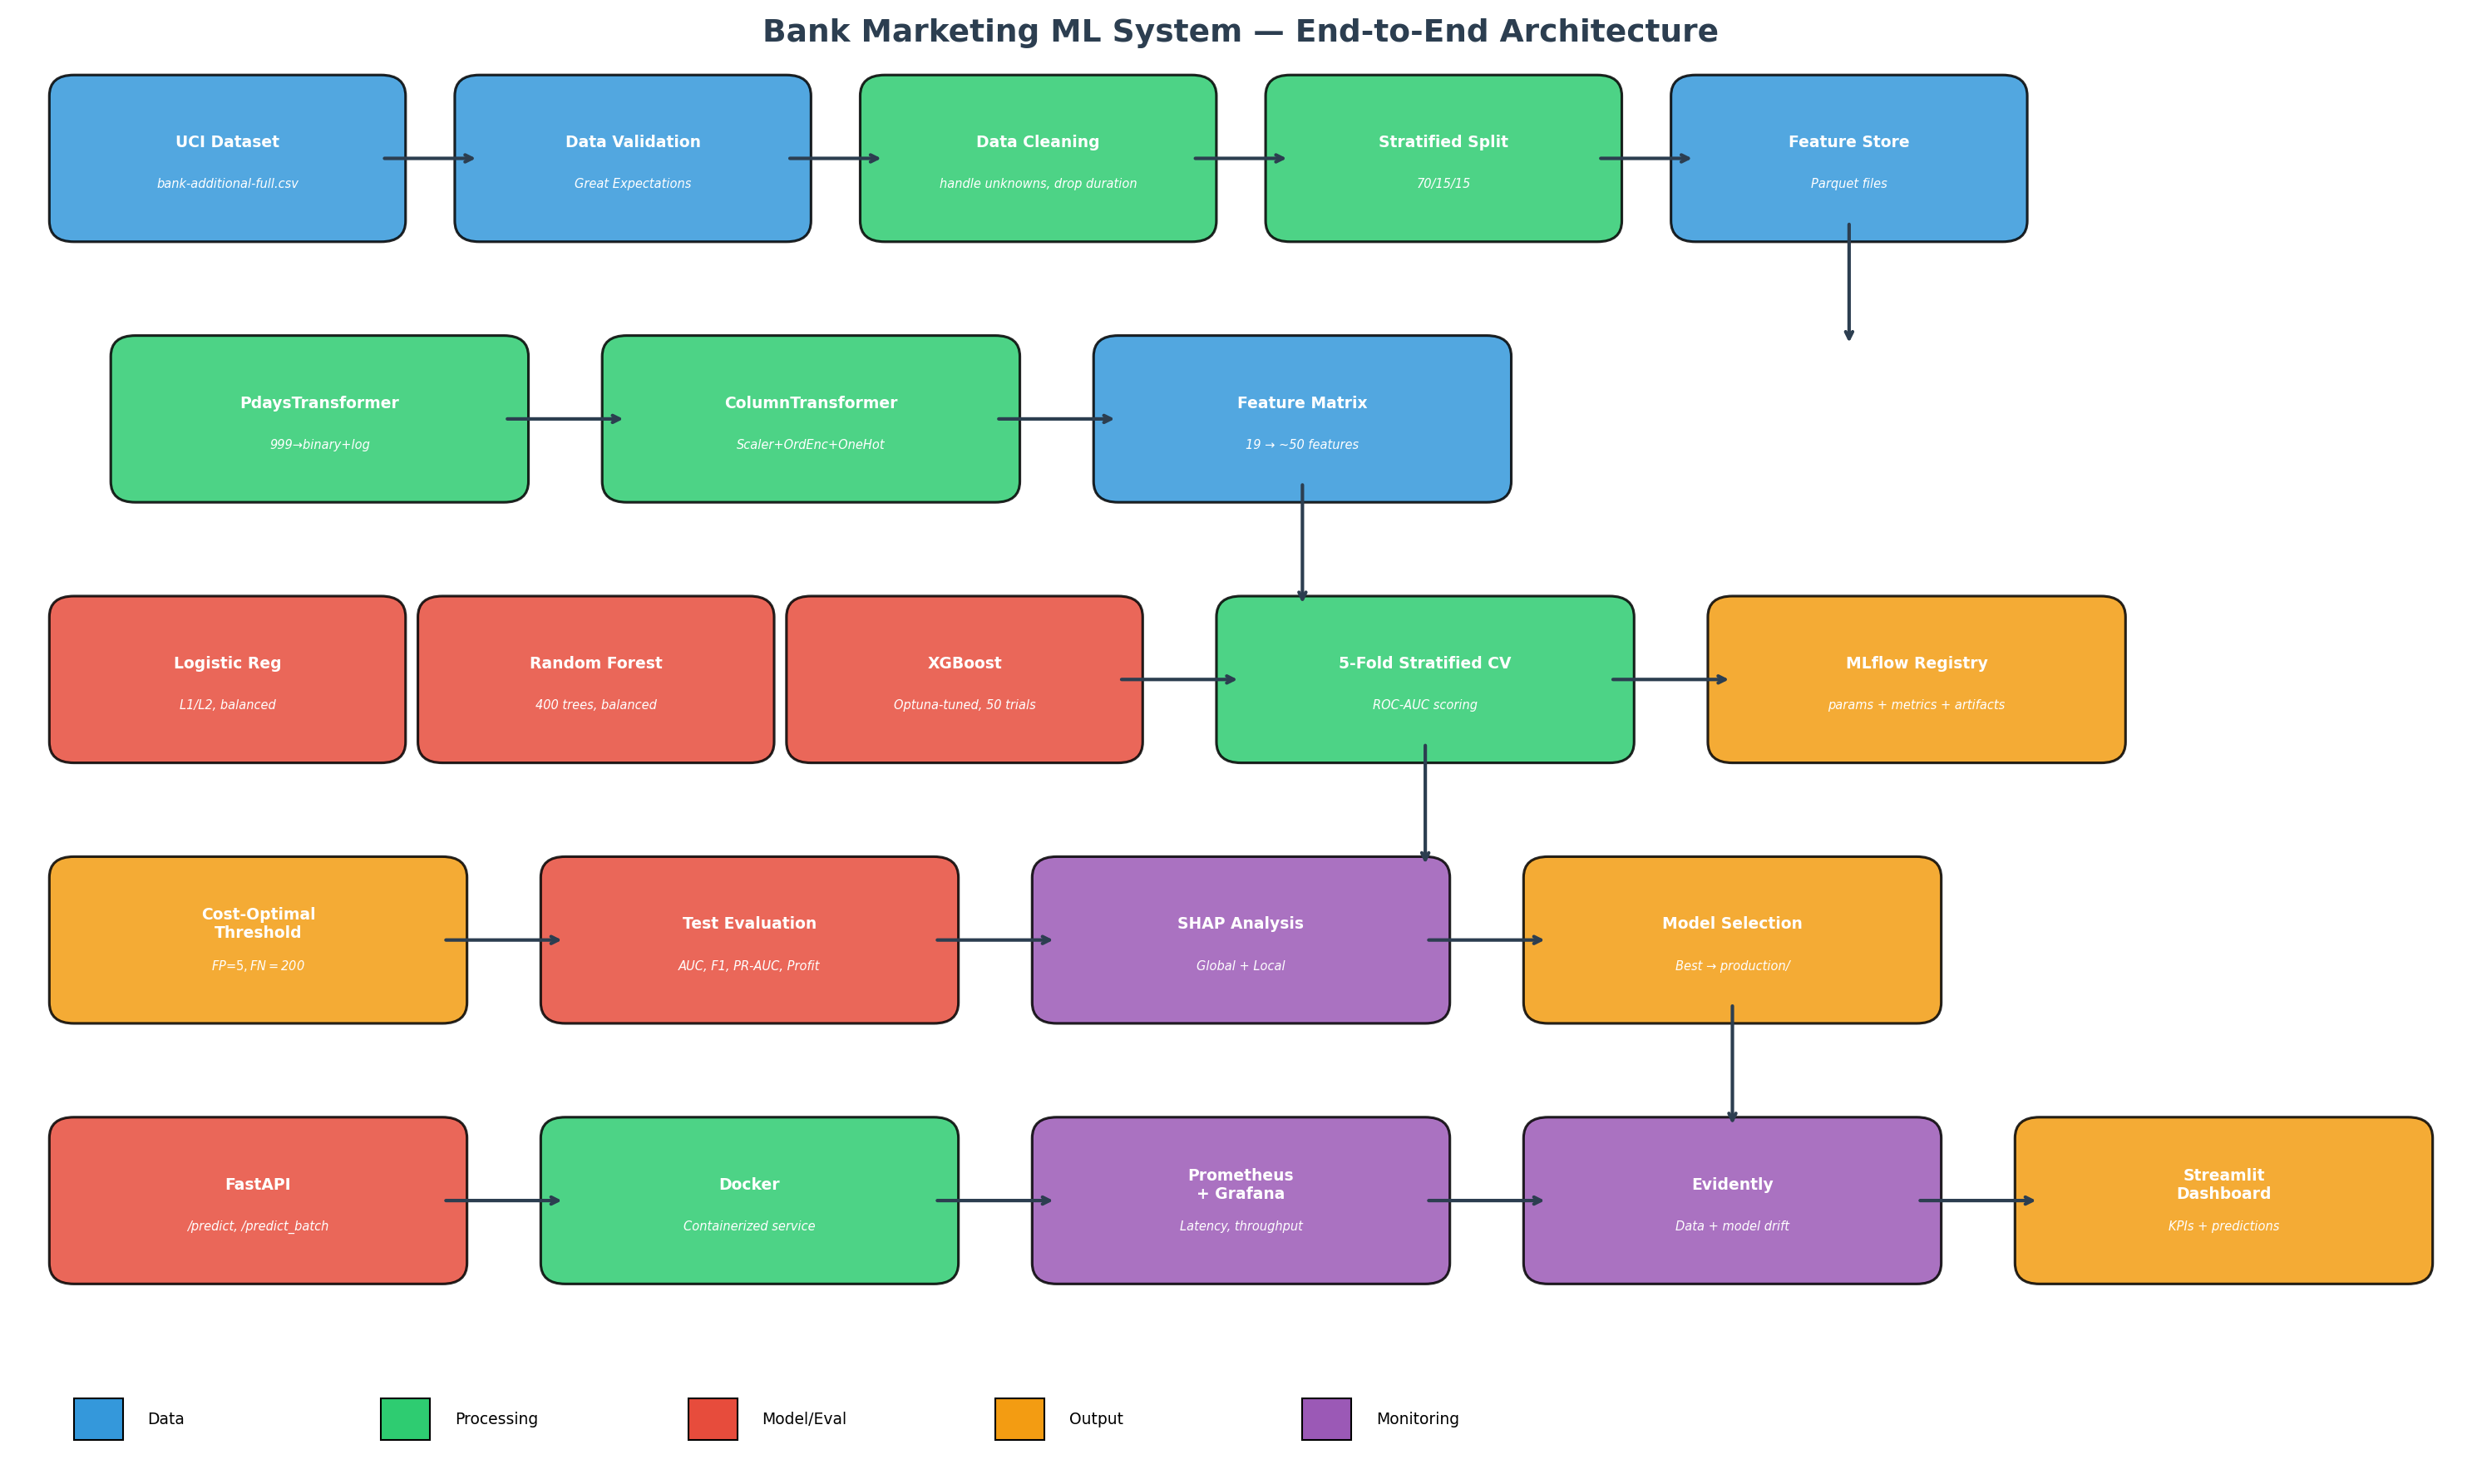

✅ Architecture diagram saved


In [4]:
# === CELL 3: End-to-End Pipeline Flow Diagram ===
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_xlim(0, 20)
ax.set_ylim(0, 14)
ax.axis("off")

# Color scheme
colors = {
    "data": "#3498db",
    "process": "#2ecc71",
    "model": "#e74c3c",
    "output": "#f39c12",
    "monitor": "#9b59b6",
    "arrow": "#2c3e50",
}

def draw_box(ax, x, y, w, h, text, color, fontsize=9, subtext=None):
    rect = mpatches.FancyBboxPatch(
        (x, y), w, h, boxstyle="round,pad=0.2",
        facecolor=color, edgecolor="black", linewidth=1.5, alpha=0.85
    )
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2 + (0.15 if subtext else 0), text,
            ha="center", va="center", fontsize=fontsize, fontweight="bold", color="white")
    if subtext:
        ax.text(x + w/2, y + h/2 - 0.25, subtext,
                ha="center", va="center", fontsize=7, color="white", style="italic")

def draw_arrow(ax, x1, y1, x2, y2):
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", color=colors["arrow"], lw=2))

# === ROW 1: Data Layer ===
draw_box(ax, 0.5, 12, 2.5, 1.2, "UCI Dataset", colors["data"], subtext="bank-additional-full.csv")
draw_arrow(ax, 3.0, 12.6, 3.8, 12.6)
draw_box(ax, 3.8, 12, 2.5, 1.2, "Data Validation", colors["data"], subtext="Great Expectations")
draw_arrow(ax, 6.3, 12.6, 7.1, 12.6)
draw_box(ax, 7.1, 12, 2.5, 1.2, "Data Cleaning", colors["process"], subtext="handle unknowns, drop duration")
draw_arrow(ax, 9.6, 12.6, 10.4, 12.6)
draw_box(ax, 10.4, 12, 2.5, 1.2, "Stratified Split", colors["process"], subtext="70/15/15")
draw_arrow(ax, 12.9, 12.6, 13.7, 12.6)
draw_box(ax, 13.7, 12, 2.5, 1.2, "Feature Store", colors["data"], subtext="Parquet files")

# === ROW 2: Feature Engineering ===
draw_arrow(ax, 14.95, 12, 14.95, 10.8)
draw_box(ax, 1, 9.5, 3, 1.2, "PdaysTransformer", colors["process"], subtext="999→binary+log")
draw_arrow(ax, 4.0, 10.1, 5.0, 10.1)
draw_box(ax, 5, 9.5, 3, 1.2, "ColumnTransformer", colors["process"], subtext="Scaler+OrdEnc+OneHot")
draw_arrow(ax, 8.0, 10.1, 9.0, 10.1)
draw_box(ax, 9, 9.5, 3, 1.2, "Feature Matrix", colors["data"], subtext="19 → ~50 features")

# === ROW 3: Model Training ===
draw_arrow(ax, 10.5, 9.5, 10.5, 8.3)
draw_box(ax, 0.5, 7, 2.5, 1.2, "Logistic Reg", colors["model"], subtext="L1/L2, balanced")
draw_box(ax, 3.5, 7, 2.5, 1.2, "Random Forest", colors["model"], subtext="400 trees, balanced")
draw_box(ax, 6.5, 7, 2.5, 1.2, "XGBoost", colors["model"], subtext="Optuna-tuned, 50 trials")
draw_arrow(ax, 9.0, 7.6, 10.0, 7.6)
draw_box(ax, 10, 7, 3, 1.2, "5-Fold Stratified CV", colors["process"], subtext="ROC-AUC scoring")
draw_arrow(ax, 13, 7.6, 14, 7.6)
draw_box(ax, 14, 7, 3, 1.2, "MLflow Registry", colors["output"], subtext="params + metrics + artifacts")

# === ROW 4: Evaluation ===
draw_arrow(ax, 11.5, 7, 11.5, 5.8)
draw_box(ax, 0.5, 4.5, 3, 1.2, "Cost-Optimal\nThreshold", colors["output"], subtext="FP=$5, FN=$200")
draw_arrow(ax, 3.5, 5.1, 4.5, 5.1)
draw_box(ax, 4.5, 4.5, 3, 1.2, "Test Evaluation", colors["model"], subtext="AUC, F1, PR-AUC, Profit")
draw_arrow(ax, 7.5, 5.1, 8.5, 5.1)
draw_box(ax, 8.5, 4.5, 3, 1.2, "SHAP Analysis", colors["monitor"], subtext="Global + Local")
draw_arrow(ax, 11.5, 5.1, 12.5, 5.1)
draw_box(ax, 12.5, 4.5, 3, 1.2, "Model Selection", colors["output"], subtext="Best → production/")

# === ROW 5: Deployment & Monitoring ===
draw_arrow(ax, 14, 4.5, 14, 3.3)
draw_box(ax, 0.5, 2, 3, 1.2, "FastAPI", colors["model"], subtext="/predict, /predict_batch")
draw_arrow(ax, 3.5, 2.6, 4.5, 2.6)
draw_box(ax, 4.5, 2, 3, 1.2, "Docker", colors["process"], subtext="Containerized service")
draw_arrow(ax, 7.5, 2.6, 8.5, 2.6)
draw_box(ax, 8.5, 2, 3, 1.2, "Prometheus\n+ Grafana", colors["monitor"], subtext="Latency, throughput")
draw_arrow(ax, 11.5, 2.6, 12.5, 2.6)
draw_box(ax, 12.5, 2, 3, 1.2, "Evidently", colors["monitor"], subtext="Data + model drift")
draw_arrow(ax, 15.5, 2.6, 16.5, 2.6)
draw_box(ax, 16.5, 2, 3, 1.2, "Streamlit\nDashboard", colors["output"], subtext="KPIs + predictions")

# Title
ax.text(10, 13.8, "Bank Marketing ML System — End-to-End Architecture",
        ha="center", va="center", fontsize=18, fontweight="bold", color="#2c3e50")

# Legend
legend_items = [
    ("Data", colors["data"]),
    ("Processing", colors["process"]),
    ("Model/Eval", colors["model"]),
    ("Output", colors["output"]),
    ("Monitoring", colors["monitor"]),
]
for i, (label, color) in enumerate(legend_items):
    ax.add_patch(mpatches.Rectangle((0.5 + i*2.5, 0.3), 0.4, 0.4,
                                     facecolor=color, edgecolor="black"))
    ax.text(1.1 + i*2.5, 0.5, label, fontsize=9, va="center")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "full_architecture.png", bbox_inches="tight", dpi=150)
plt.show()
print("✅ Architecture diagram saved")

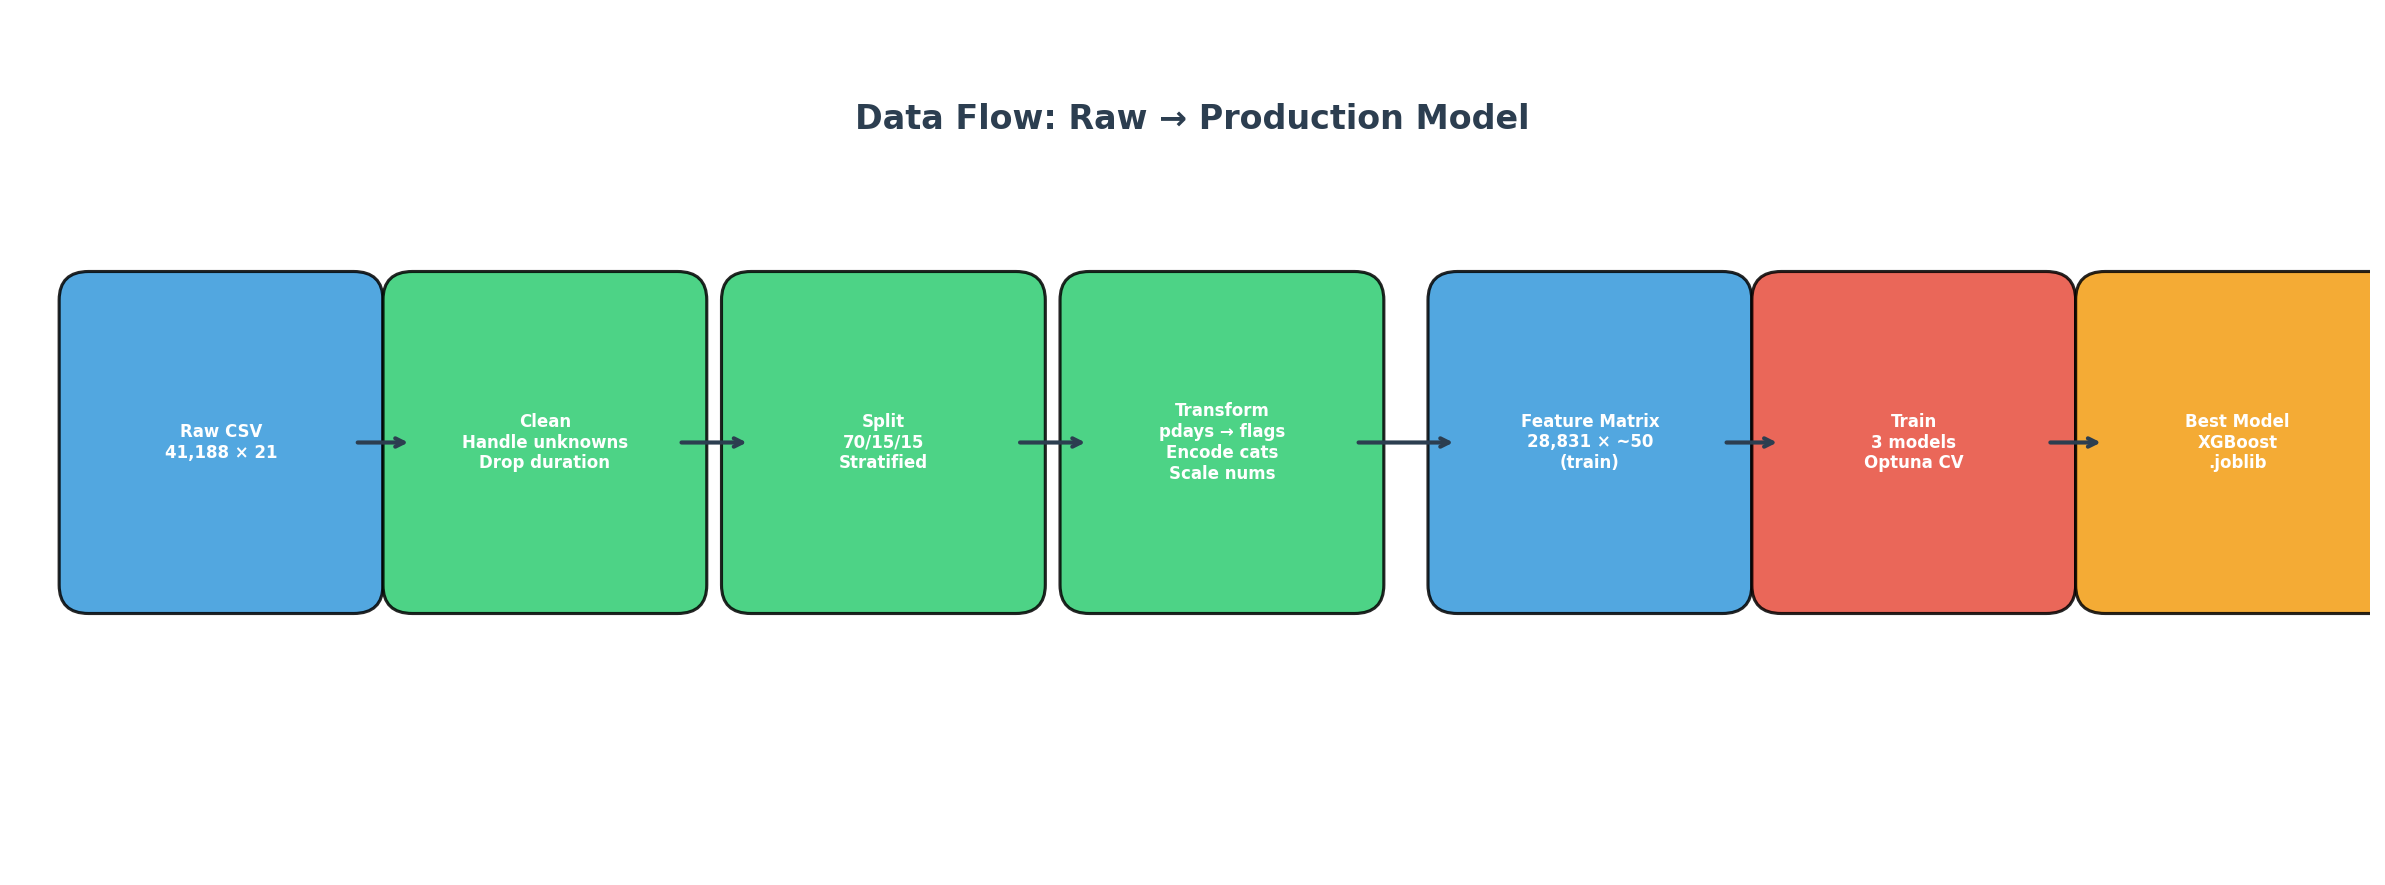

In [5]:
# === CELL 4: Data Flow Diagram ===
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlim(0, 16)
ax.set_ylim(0, 6)
ax.axis("off")

steps = [
    ("Raw CSV\n41,188 × 21", 0.5, colors["data"]),
    ("Clean\nHandle unknowns\nDrop duration", 2.7, colors["process"]),
    ("Split\n70/15/15\nStratified", 5.0, colors["process"]),
    ("Transform\npdays → flags\nEncode cats\nScale nums", 7.3, colors["process"]),
    ("Feature Matrix\n28,831 × ~50\n(train)", 9.8, colors["data"]),
    ("Train\n3 models\nOptuna CV", 12.0, colors["model"]),
    ("Best Model\nXGBoost\n.joblib", 14.2, colors["output"]),
]

for text, x, color in steps:
    draw_box(ax, x, 2, 1.8, 2, text, color, fontsize=8)

for i in range(len(steps) - 1):
    x1 = steps[i][1] + 1.8
    x2 = steps[i+1][1]
    draw_arrow(ax, x1, 3, x2, 3)

ax.text(8, 5.2, "Data Flow: Raw → Production Model",
        ha="center", fontsize=16, fontweight="bold", color="#2c3e50")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "data_flow.png", bbox_inches="tight", dpi=150)
plt.show()

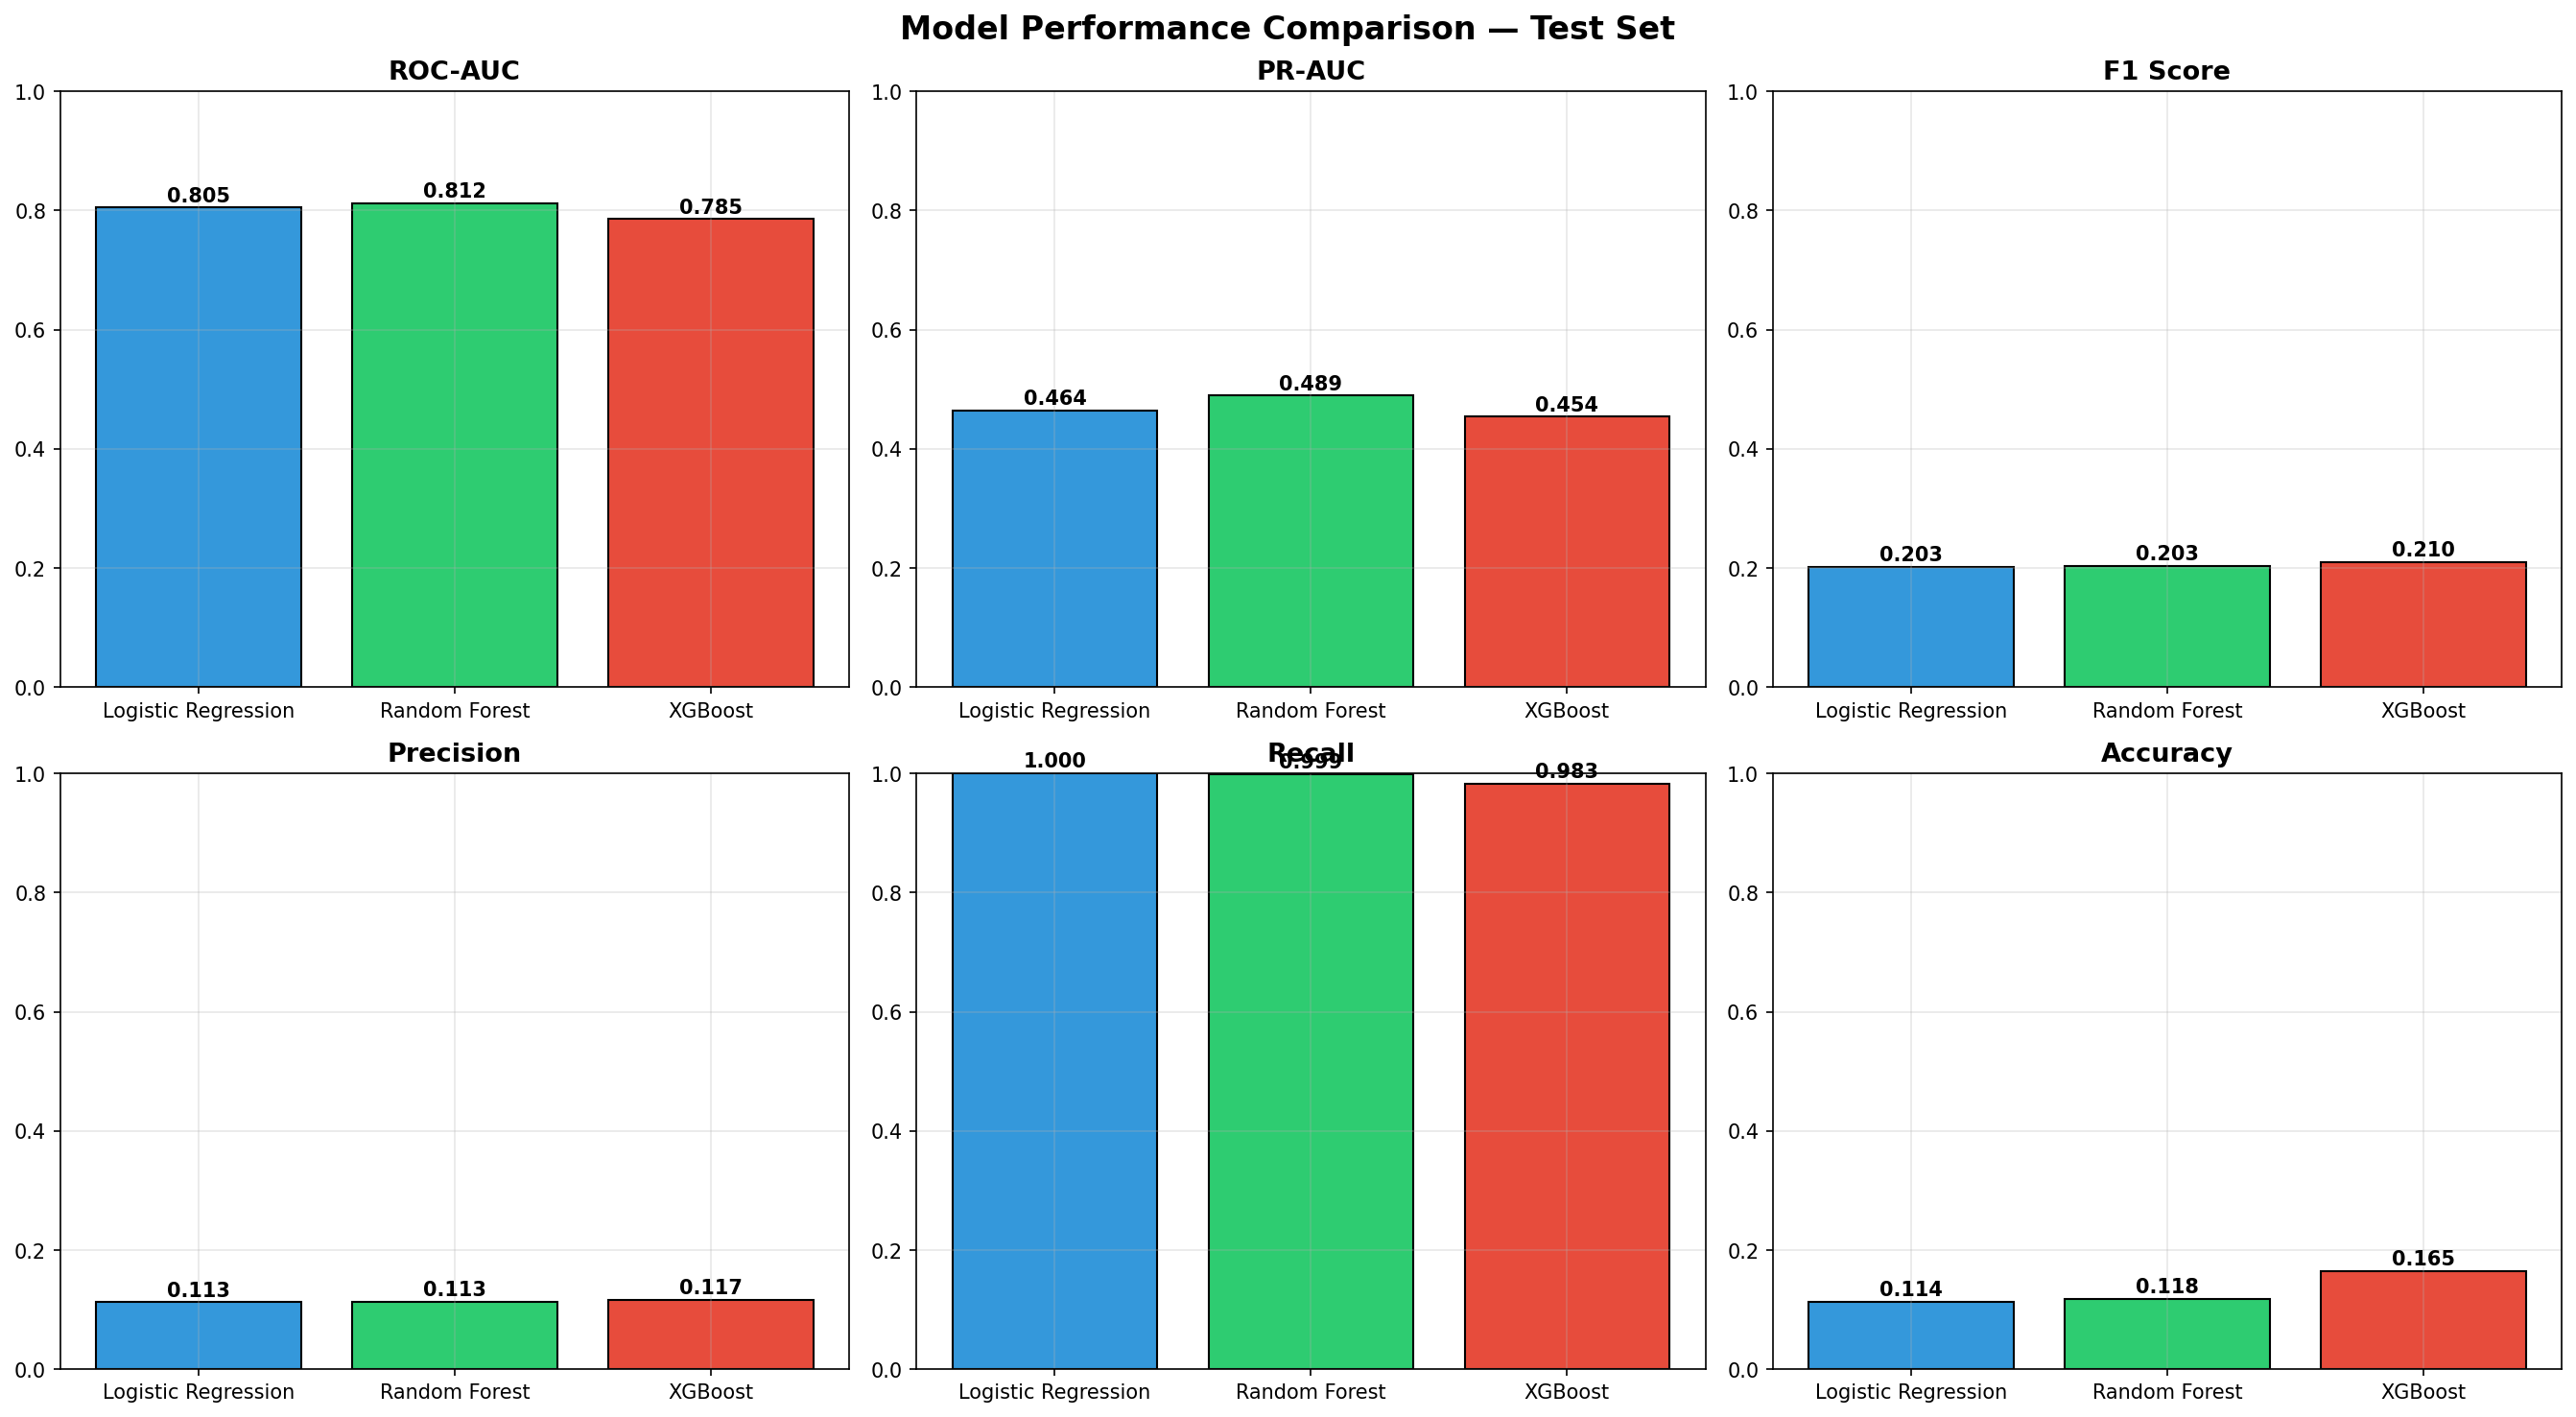

In [7]:
# === CELL 5: Model Comparison Dashboard ===
METRICS_DIR = PROJECT_ROOT / "reports" / "metrics"

comparison_path = METRICS_DIR / "comparison.json"
if comparison_path.exists():
    results = pd.read_json(comparison_path)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # Map to actual column names in comparison.json (Model, roc_auc, pr_auc, f1, precision, recall, accuracy)
    metrics_to_plot = ["roc_auc", "pr_auc", "f1", "precision", "recall", "accuracy"]
    titles = ["ROC-AUC", "PR-AUC", "F1 Score", "Precision", "Recall", "Accuracy"]
    colors_bars = ["#3498db", "#2ecc71", "#e74c3c"]
    model_col = "Model" if "Model" in results.columns else "model"

    for ax, metric, title in zip(axes.flatten(), metrics_to_plot, titles):
        if metric in results.columns:
            bars = ax.bar(results[model_col], results[metric], color=colors_bars, edgecolor="black")
            ax.set_title(title, fontsize=13, fontweight="bold")
            ax.set_ylim(0, 1)
            for bar, val in zip(bars, results[metric]):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f"{val:.3f}", ha="center", fontsize=10, fontweight="bold")
        else:
            ax.text(0.5, 0.5, f"'{metric}' not found", ha="center", va="center", transform=ax.transAxes)
        ax.grid(True, alpha=0.3)

    plt.suptitle("Model Performance Comparison — Test Set", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "model_comparison_dashboard.png", bbox_inches="tight")
    plt.show()
else:
    print("⚠️ No comparison.json found. Run Notebook 03 first.")


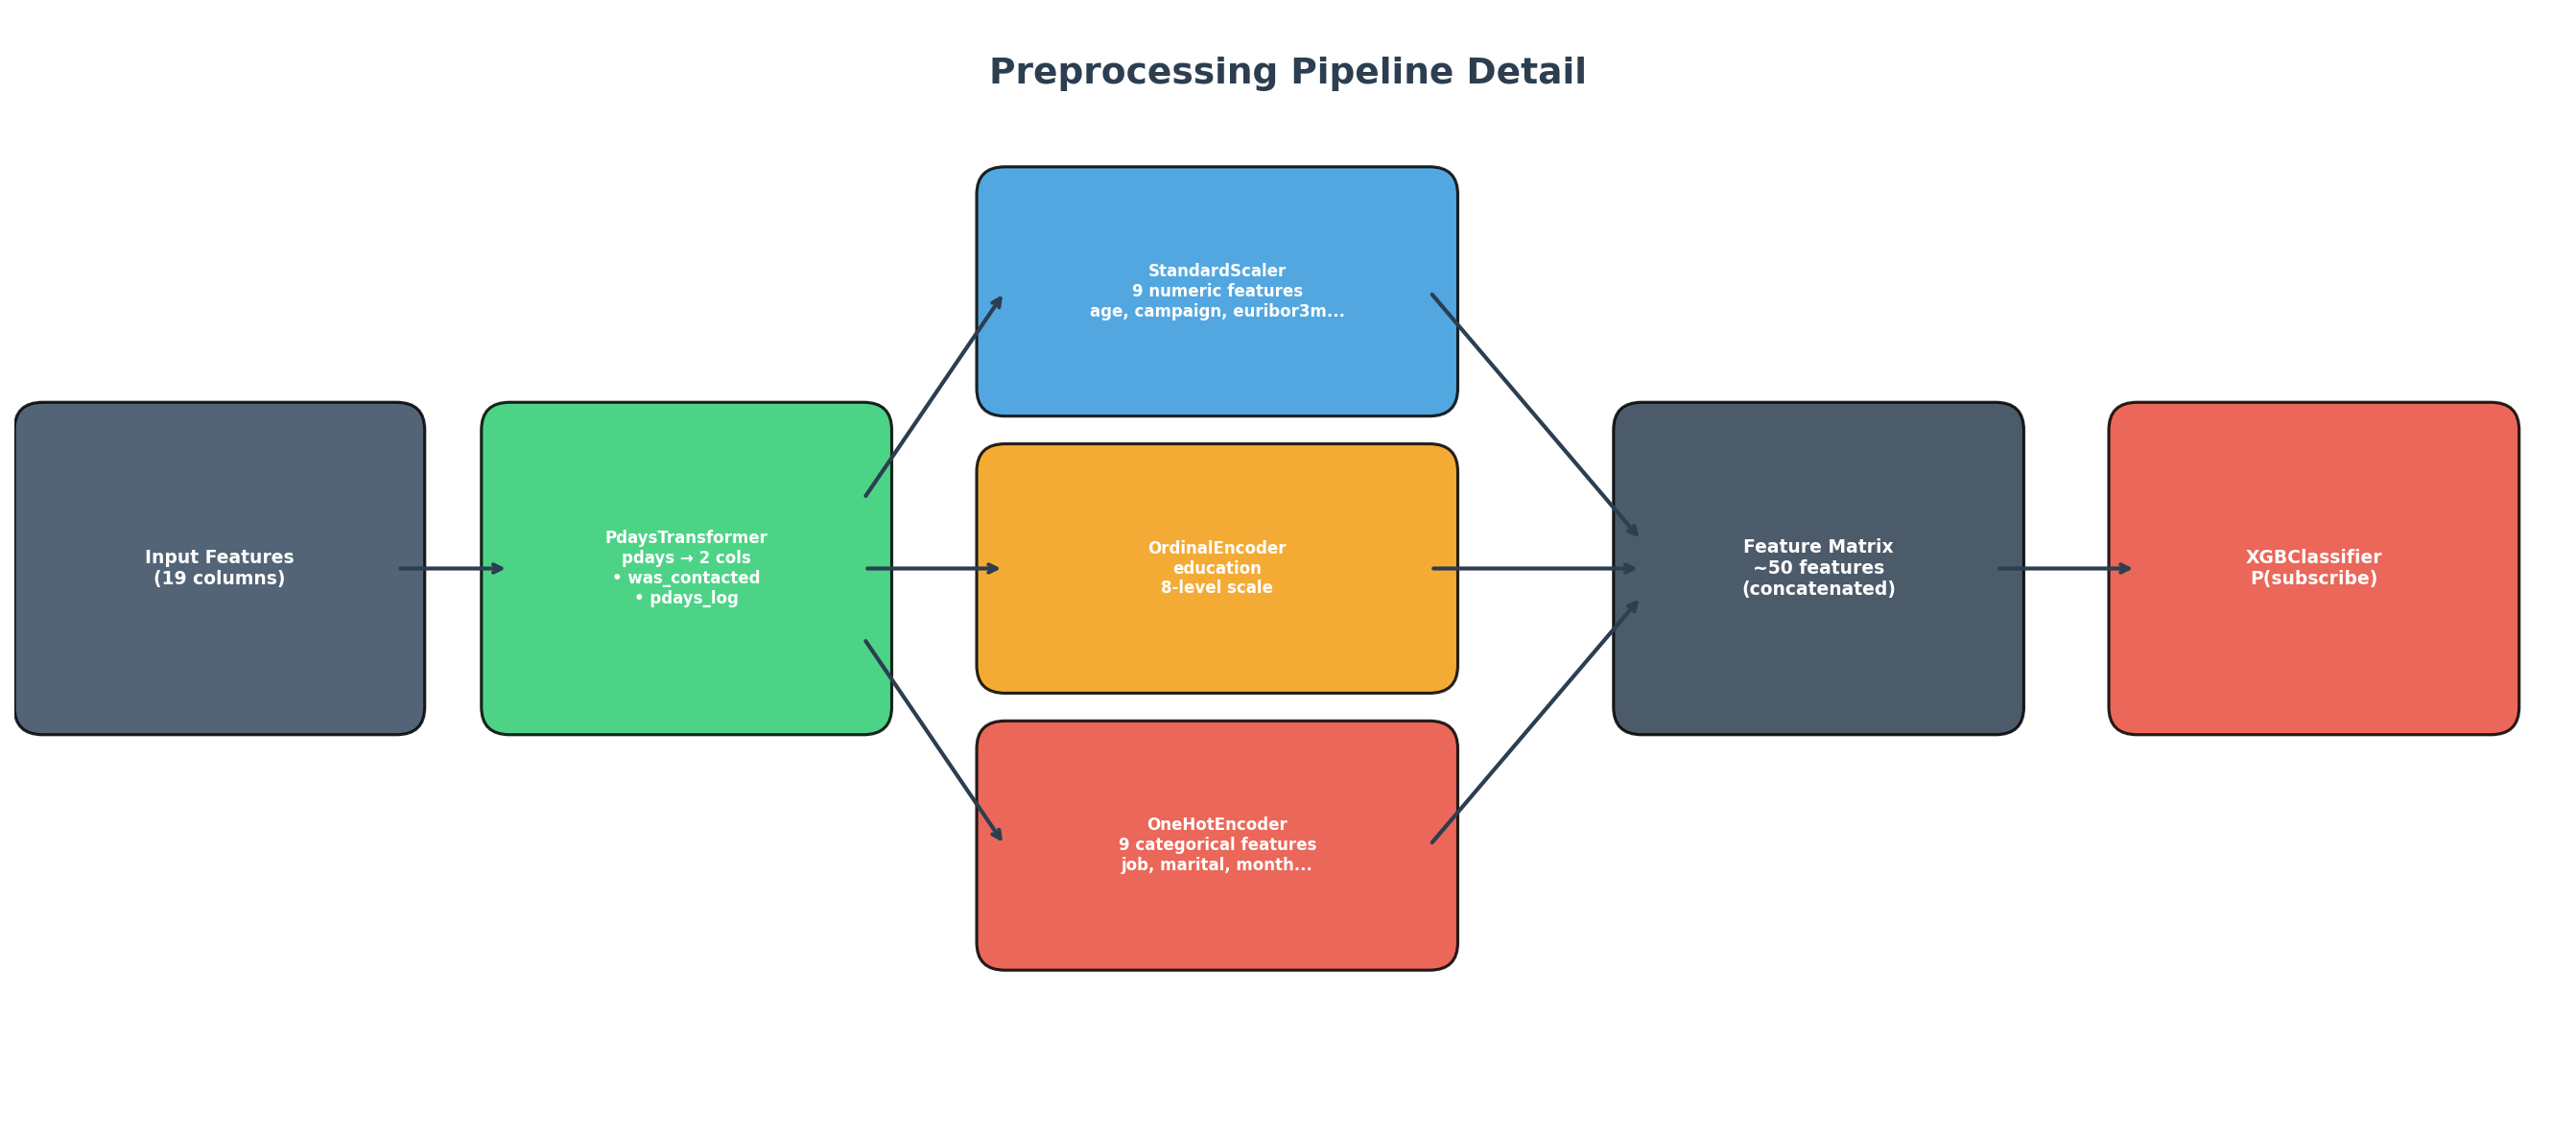

In [8]:
# === CELL 6: Preprocessing Pipeline Detail ===
fig, ax = plt.subplots(figsize=(18, 8))
ax.set_xlim(0, 18)
ax.set_ylim(0, 8)
ax.axis("off")

ax.text(9, 7.5, "Preprocessing Pipeline Detail", ha="center",
        fontsize=18, fontweight="bold", color="#2c3e50")

# Input
draw_box(ax, 0.2, 3, 2.5, 2, "Input Features\n(19 columns)", "#34495e", fontsize=9)

# PdaysTransformer
draw_arrow(ax, 2.7, 4, 3.5, 4)
draw_box(ax, 3.5, 3, 2.5, 2, "PdaysTransformer\npdays → 2 cols\n• was_contacted\n• pdays_log", colors["process"], fontsize=8)

# Split into 3 branches
draw_arrow(ax, 6.0, 4.5, 7.0, 6.0)
draw_arrow(ax, 6.0, 4.0, 7.0, 4.0)
draw_arrow(ax, 6.0, 3.5, 7.0, 2.0)

# Numeric branch
draw_box(ax, 7, 5.3, 3, 1.4, "StandardScaler\n9 numeric features\nage, campaign, euribor3m...", colors["data"], fontsize=8)

# Ordinal branch
draw_box(ax, 7, 3.3, 3, 1.4, "OrdinalEncoder\neducation\n8-level scale", "#f39c12", fontsize=8)

# Nominal branch
draw_box(ax, 7, 1.3, 3, 1.4, "OneHotEncoder\n9 categorical features\njob, marital, month...", "#e74c3c", fontsize=8)

# Merge
draw_arrow(ax, 10, 6.0, 11.5, 4.2)
draw_arrow(ax, 10, 4.0, 11.5, 4.0)
draw_arrow(ax, 10, 2.0, 11.5, 3.8)

draw_box(ax, 11.5, 3, 2.5, 2, "Feature Matrix\n~50 features\n(concatenated)", "#2c3e50", fontsize=9)

# Classifier
draw_arrow(ax, 14, 4, 15, 4)
draw_box(ax, 15, 3, 2.5, 2, "XGBClassifier\nP(subscribe)", colors["model"], fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "preprocessing_pipeline_detail.png", bbox_inches="tight", dpi=150)
plt.show()

In [9]:
# === CELL 7: Summary of All Generated Figures ===
print("=" * 60)
print("📋 ALL FIGURES GENERATED ACROSS NOTEBOOKS")
print("=" * 60)

for fig_path in sorted(FIGURES_DIR.glob("*.png")):
    size_kb = fig_path.stat().st_size / 1024
    print(f"  📊 {fig_path.name:45s} ({size_kb:.0f} KB)")

print(f"\nTotal figures: {len(list(FIGURES_DIR.glob('*.png')))}")
print(f"Location: {FIGURES_DIR}")

📋 ALL FIGURES GENERATED ACROSS NOTEBOOKS
  📊 boxplots_by_target.png                        (122 KB)
  📊 business_feature_importance.png               (98 KB)
  📊 business_impact.png                           (44 KB)
  📊 categorical_distributions.png                 (137 KB)
  📊 confusion_matrices_all.png                    (57 KB)
  📊 confusion_matrix_random_forest.png            (32 KB)
  📊 conversion_by_category.png                    (160 KB)
  📊 correlation_matrix.png                        (126 KB)
  📊 cv_comparison.png                             (45 KB)
  📊 data_flow.png                                 (76 KB)
  📊 duration_warning.png                          (52 KB)
  📊 feature_selection_scores.png                  (112 KB)
  📊 feature_subset_evaluation.png                 (33 KB)
  📊 full_architecture.png                         (220 KB)
  📊 macro_correlations.png                        (58 KB)
  📊 model_comparison_dashboard.png                (94 KB)
  📊 mutual_information.pn